# Clustering y PCA sobre dataset de work-life balance

## Laboratorio 2022 - Tarea 4

### Grupo 27

Alexis Baladón, CI: 5.574.612-4

Ignacio Viscardi, CI: 5.066.666-2

Rafael Castelli, CI: 5.079.391-2

## Requisitos para reproducción de algoritmo

Para correr el presente notebook se deberán instalar las siguientes dependencias. Queda un script para su instalación automática.

In [ ]:
!pip install -r requirements.txt

## 2. Decisiones de diseño

La finalidad de esta sección consiste en introducir las principales decisiones de diseño tomadas para esta implementación de K-means.

### 2.1 Preprocesado

Primeramente, se elimina el nombre de la ciudad y país del conjunto de datos. Esto se hace debido a que ambos son atributos categóricos, por lo que sería necesaria una técnica como one-hot encoding para trabajar sobre ellos, pudiendo tener efectos indeseados al calcular la distancia euclídea (especialmente al normalizar los datos) debido a la maldición de la dimensionalidad. Más aún, no fueron considerados relevantes para medir el work-life balance.
Por otra parte, también se eliminó la columna 2021 y 2022 ya que estos atributos no parecen ser relevantes para el problema en cuestión, además de ser identificadores únicos de cada tupla.

En la seccion 3 (Experimentación) se mencionarán, cuando se considere adecuado, otras variables que fueron eliminadas del conjunto de datos para realizar los experimentos pertinentes.

### 2.2 Metaparametros

-- explicar los metaparametros

### 2.3 Metodo de inicialización
Se consideraron 2 métodos de inicialización para los centroides del algoritmo K-means. 
Uno de los métodos realiza una selección aleatoria de K elementos del espacio de posibles elementos (se considera que un elemento x esta en el espacio de posibles elementos si para cada coordenada su valor es menor o igual que el maximo valor, en valor absoluto, que puede tomar dicha coordenada en el dataset provisto).

El otro método de inicialización considerado consiste en tomar k elementos del dataset (al azar) como centroides iniciales. Según lo visto en el teórico del curso, este método debería tener mejores propiedades de convergencia y ser menos propenso a dejar clusters vacios durante la ejecución.

#TODO: demostrar convergencia de ambos métodos (aclaracion, agregar graficas en la que se note eso, y tirar un comentario asi noma)

### 2.4 Manejo de cluster vacios en kmeans
Dado que el algoritmo k-means presentado en el curso no contempla el caso de generar cluster vacios, entonces fue necesario agregar cierta logica al algoritmo de modo que esto no ocurra.
Lo que se hizo para solventar ese problema fue chequar en cada iteración del algoritmo, luego de asignar los elementos a los clusters, si alguno de los clusters quedaba vacio. En caso de que esto ocurriera, se procedia a reasignar los centroides vacios de modo de que el cluster que forma contenga al menos un elemento. Luego de esto se volvió a asignar los elementos a los clusters, y en caso de que el problema anterior ocurriera devuelta entonces se vuelve a realizar la técnica antes mencionada hasta que el problema ya no este presente. 
Una vez no tengo clusters vacios se procede con el algoritmo como corresponde.

Notese que la técnica utilizada para reasignar los centroides consistió en tomar el elemento del dataset mas cercano al centroide del cluster vacio y asignar dicho elemento como nuevo centrodide del cluster. De esta manera nos aseguramnos de que el cluster contenga al menos un elemento.

## 3 Experimentos

Para la experimentación, se considera el conjunto de datos sin normalizar y luego normalizado, de forma de contrastar el efecto que la normalización puede tener en el algoritmo kmeans. Dado que la mayoría de los datos están en una escala de 0 a 100, y aquellos que no están, tampoco tienen escalas muy distintas, entonces parece razonable empezar sin normalizar los datos, para evitar perturbaciones a la varianza y los clusters producidos.

En lo que sigue, se distinguen 3 casos del conjunto de datos: original_df corresponde al conjunto de datos tal cual se carga directamente del CSV, sin realizarle ningún preprocesado. Dicho objeto se utiliza para encontrar a Montevideo (y potencialmente otras ciudades) dentro de los datos. minimal_preprocess_df corresponde al conjunto de datos donde el único preprocesado que se hace es eliminar las columnas nombradas en la sección 2.1 y eventualmente la normalización de los datos. Por último df corresponde al dataset con donde se eliminan todas las columnas que se consideraron irrelevantes dado el análisis del dataset.

### 3.1 Sin normalizacion


Prerequisitos:

Antes de correr todos los test que siguen, es necesario correr esta celda de código con el fin de cargar algunas variables que serán reutilizadas a lo largo de la experimentación.

In [1]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

Análisis de valores propios

Para tener una idea del número de dimensiones relevantes y por panto una potencial pista del número de columnas irrelevantes de las cuales se puede prescindir, se grafican los valores propios para ver las magnitudes de los mismos y compararlas. Se empieza con una escala lineal.

Eigenvalues (Escala lineal)

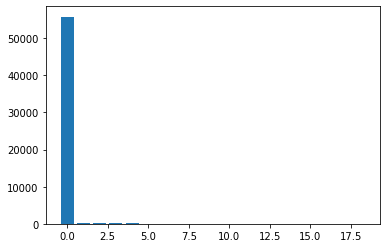

In [3]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=False)

Claramente la escala lineal muestra que existe un valor propio que domina ámpliamente a los demás. Para poder apreciar mejor el comportamiento de los demás valores propios, se repite el experimento sin considerar el primer valor propio. Como adjunto se grafican los valores propios en escala logaritmica.

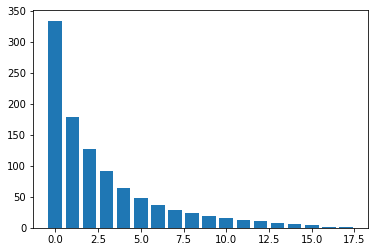

In [6]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=True)

Claramente se tiene un valor propio ampliamente dominante sobre el resto, y el segundo valor propio más grande es aproximadamente 2 veces el tercer valor propio más grande. Luego, se concluye que existe lugar para descartar algunas columnas (se visualiza mejor al analizar la matríz de covarianza), y es claro que se deben conservar al menos 2 o 3 dimensiones. Luego, empieza a ser discutible donde se puede realizar el punto de corte para dejar de descartar dimensiones.

Se recuerda que dichas dimensiones (las dadas por PCA) no se corresponden directamente con las dimensiones del conjunto de datos original pero puede dar una idea sobre la importancia relativa de las distintas dimensiones.

No obstante, en este caso no resulta extremadamente evidente las conclusiones que se puedan sacar.

Eigenvalues (Escala logaritmica)

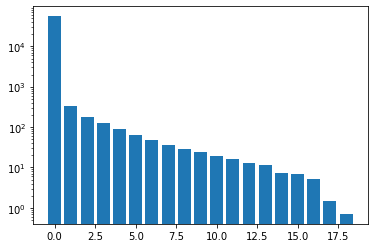

In [5]:
test.PCA_eigen_values(minimal_preprocess_df, scale="log", drop_first=False)

Para continuar con la selección de atributos, se analiza la covarianza entre los distintos atributos. Particularmente, ya que es de interés analizar la interdependencia de los distintos atributos y no tanto si un atributo influye positivamente o negativamente sobre otro, se toma el valor absoluto de la covarianza para facilitar el análisis visual.

covariance_matrix

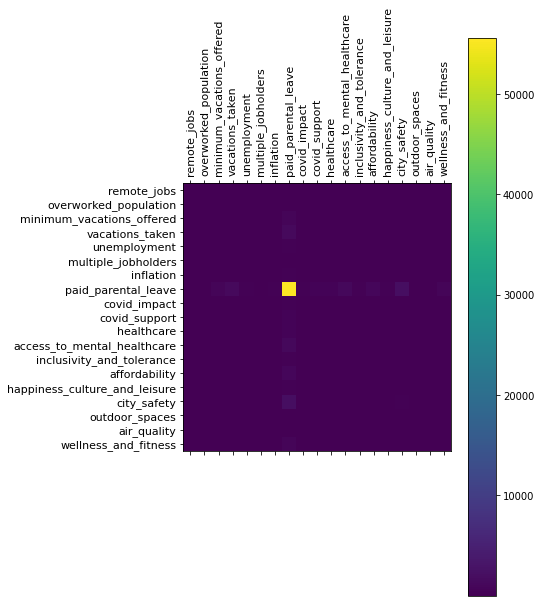

In [7]:
test.abs_covariance_matrix(minimal_preprocess_df)

Como ilustra la imagen anterior, las escalas de la matriz de covarianza no facilitan el análisis visual de la situación. Por esto, se utiliza el valor absoluto de la correlación.

correlation matrix

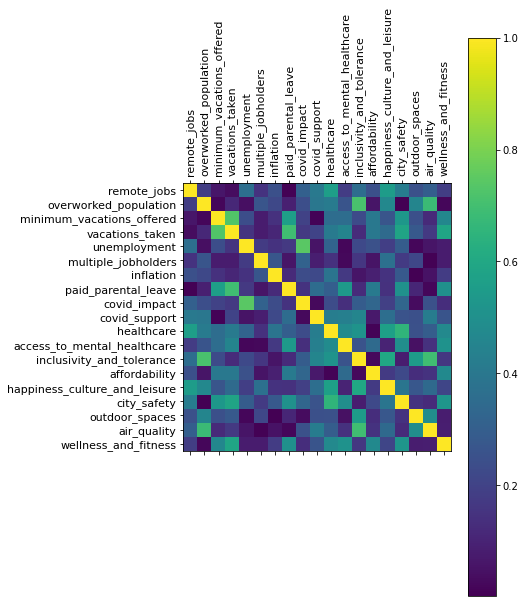

In [8]:
test.abs_correlation_matrix(minimal_preprocess_df)

Gráficamente la situación mejora, ahora se distinguen atributos que están claramente correlacionados, como "minimun_vacations_offered" y "vacations_taken". Algunas de estas correlaciones parecen muy intuitivas (como la anterior) y otras pueden ser discutibles.

Se presenta la matriz de correlación absoluta que se obtiene luego de la selección de atributos. Luego se presenta una herramienta utilizada para la selección de atributos y por último se da una explicación de la selección realizada. Como estrategia general, dados dos atributos A1 y A2, se intenta eliminar uno de los dos si ambos están muy correlacionados (positiva o negativamente) pues es esperable que no aporten mucha información adicional y removerlos contribuye a reducir la dimensionalidad del dataset y potencialmente mejorar la calidad de las técnicas aplicadas. Notar que en esta estrategia no se consideran correlaciones entre 3 o más atributos conjuntamente.

Correlation matrix (non minimal)

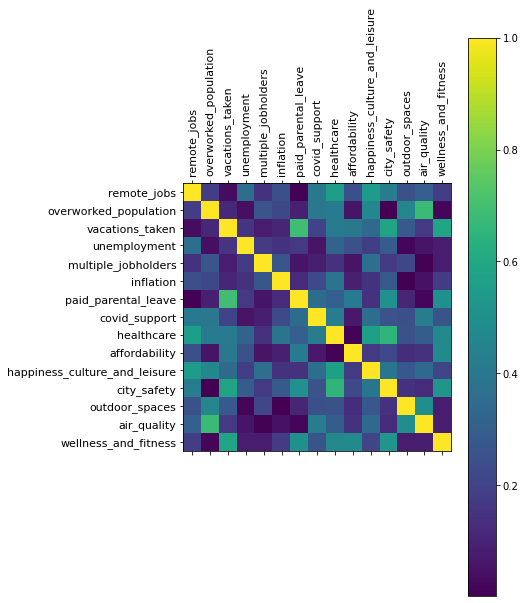

In [9]:
test.abs_correlation_matrix(df)

Como otra herramienta utilizada, se utiliza la misma matriz de correlación absoluta pero filtrada con un punto de corte tal que: si xij > punto de corte entonces xij <- 1 en otro caso xij <- 0.

Esto facilita la visualización de atributos altamente correlacionados, dismunuyendo gradualmente el punto de corte y observando en "orden de importancia" relaciones entre los datos.

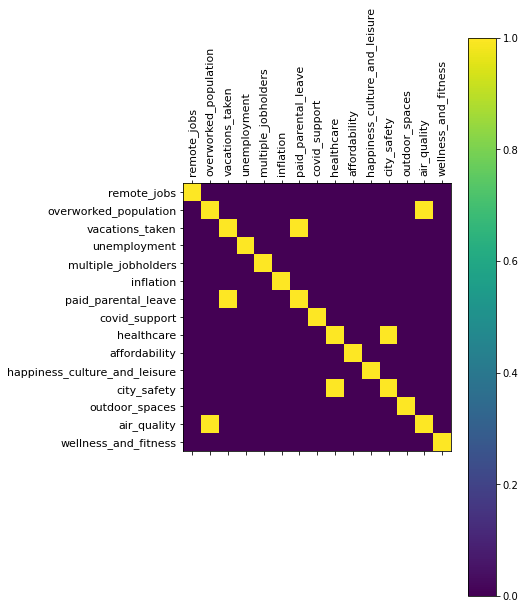

In [10]:
test.cutpoint_abs_correlation_matrix(df, cutpoint=0.60)

Healthcare y mental healthcare "a ojo" relacionados y la gráfica lo confirma => Tirar  mental healthcare

Minumun_vacations_offered y vacations_taken => quedarte con vacations_taken

Covid impact mas de 0,7 correlacion con unemployment => sacamos covid impact

inclusivity_and_tolerance => No muy relacionado con WLB y con correlación de más de 0,6 con overworked population (muy relacionado con WLB) entonces se puede borrar

silhouette

In [ ]:
k_values = [x for x in range(2, constants.MAX_K_PLUS_1)]
test.test_silhouette(k_values=k_values, dataset=df, cpu_count=os.cpu_count())

Elbow method

In [ ]:
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

PCA 2D

In [ ]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=4)

### 3.2 Con normalizacion (copiar y pegar todo lo anterior)

In [ ]:
import preprocessing
import constants
import os
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

#3.3 Visualización con PCA

PCA es un método de reducción de dimensionalidad haciendo uso de la covarianza entre los atributos del conjunto de datos con el fin de reducir solo las dimensiones que menos la afecten.

#3.3.1 PCA 2D

In [ ]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=2)

Analizando estos resultados se ve con claridad que existen puntos que aparentan pertenecer a distintos clusters. En particular, existe un conjunto de datos del lado izquierdo que parecen estar altamente relacionados, lo cual el algoritmo logra captar agrupando a todos. Por otro lado, se agrupa en otro cluster a ciudades que parecen estar relacionadas (aunque no tanto como en el conjunto antes mencionado), además de agrupar a datos que parecerían ser ruidosos. Esto parece indicar que el algoritmo logra cumplir con su objetivo, al igual que da a conocer propiedades difíciles de ver a simple vista.

#3.3.2 PCA 3D

Se analiza adicionalmente la versión tridimensional de PCA, la cual tiene la ventaja de la bidimensional en cuanto a su fácil visualización además de la menor pérdida de información.

In [ ]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
for  cluster_k in [2,4]:
    test.PCA_graph(df,original_df,dimensions=3,number_of_clusters=cluster_k)

In [ ]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()

Al estudiar los datos en tres dimensiones no parece haber mucha diferencia, 

## 4 Conclusiones

## 4.1 Resultados según expectativas iniciales
 Joya